## Low Light Response Analysis WORK IN PROGRESS

This notebook provides the steps to analyze the waveform produced by real data from a single SiPM low light response. 

In [1]:
import sys
sys.path.insert(0, '../src/sipmanalyze')
import estimate as est
import datetime

## Import Data

The first step is to import a root file using the function import_data from the estimate.py file. This function takes a string giving the location of the desired root file and returns a histogram plot and a dictionary of the following information:

- "raw_data": raw data extracted from the root file of readout values in mv-ns
- "amax": the maximum readout value in the raw data
- "amin": the minimum readout value in the raw data
- "n_bins": the number of bins in the histogram
- "bin_width": the width of each histogram bin in mv-ns
- "n": the number of counts in each bin of the histogram as an array

The boolean value "plot" can optionally be set to false to supress the output plot. 

2023-08-16 03:48:26.484128


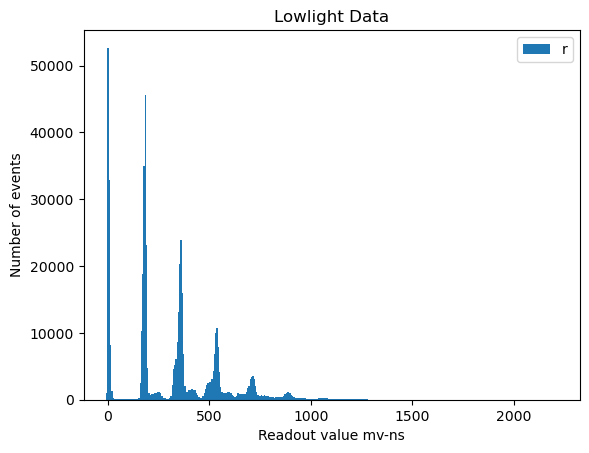

In [2]:
root_1="data/waveform_example.root"
root_2="../../root_data/picoblock_20190430_lasertrigger.root"
root_3="../../root_data/picoblock_laser_20190521.root"
root_4="../../root_data/picoblock_laser_53p1.root"
root_5="../../root_data/picoblock_laser_53p6.root"
root_6="../../root_data/picoblock_laser_54p1_20190429.root"
root_7="../../root_data/picoblock_laser_54p1.root"


file_location=root_7
import_data_results=est.import_data(file_location)


starttime=datetime.datetime.now()
print(starttime)

## Parameter Estimation: Find Peaks in the Data
In order to help speed up the fitting process, we use a simple esimation procedure of fitting gaussians to peaks to estimate values like the gain and the noise parameters found in the function get_peaks in estimate.py.

Here you find the peaks in the data assisted by the human eye. Note that the horizontal scale here uses only bin numbers, and the purpose of this step is simply to find the location of the peaks. Adjust the two parameters min_gain_guess and min_ratio_guess as necessary based on different data sets. 

Input Variables:
- OPTIONAL: min_gain_guess=80: This value gives the minimum gain that you expect in this data, and will ensure that any found peaks are not too close to one another. This value can be adjusted to be smaller if peaks are closer, or larger if extra peaks are being found.
- OPTIONAL: min_ratio_guess=1/20: This value gives the lowest peak allowed as a ratio of the height of the highest peak. This can be adjusted to require that the minimum height is a different fraction of the max peak height.
- OPTIONAL: plot = True: this boolean can be set to False to supress the output plot if desired

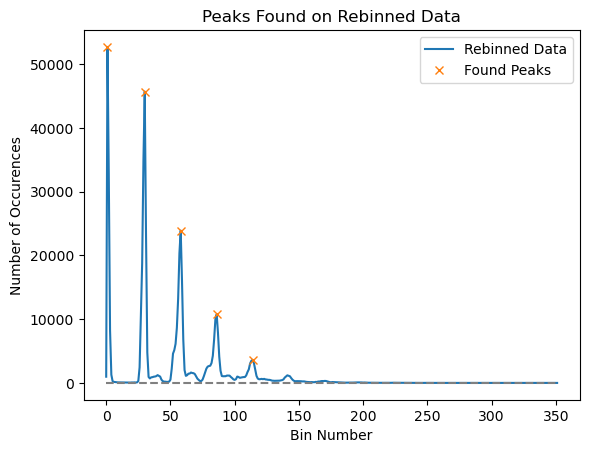

In [3]:
### Adjustable Optional Parameters ###
min_gain_guess=80
min_ratio_guess=1/20.
plot = True
#############################

peak_bin_numbers=est.get_peaks(import_data_results)

## Parameter Estimation: Fit Gaussian Curves
Here we take the peaks found in the previous step and fit simple gaussian curves to each of them. Any gaussians which are too wide or where the mean is shifted too far away from the peak are eliminated from the final data as they are poor fits.

Input Variables:
- OPTIONAL: "plot" = True: determines whether the plot is shown, can optionally be set to False
- OPTIONAL: "gauss_width" = 10: determines how many bins of data are grabbed from the center peak value to pass to the fitter in order to calculate the gaussian curve. Can be readjusted for particularly wide or thin curves if necessary. 

The data of the gaussian curves are saved in gauss_dict which saves lists for each measurement. 

Results: keys for gauss_dict
- "integral": the integral of the area under each curve
- "peak": the peak location of each peak given in terms of mv-ns
- "mu": the mean of the fitted curve for each gaussian
- "sigma": the standard deviation of the fitted curve



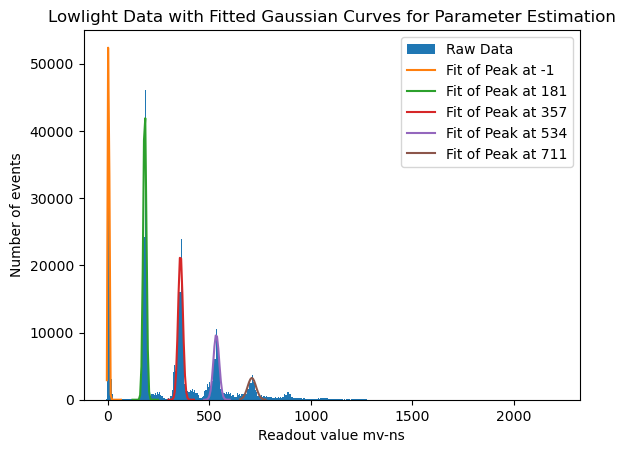

In [4]:
### Adjustable Optional Parameters ###
plot=True
gauss_width=10
#############################

gauss_dict = est.gauss_estimate(import_data_results, peak_bin_numbers)

## Parameter Estimation: Get Parameters from Gaussian Results
Taking the results from the previous gaussian fits, we use the data in order to get an estimation for the gain, common noise, pixel noise, poisson mean, and poisson borel.

/srv/.env/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Pedestal estimate:  4.9235751878841265
Gain estimate: 176.2825157490224
Common noise estimate:  1.8645165246982802
Pixel noise estimate:  5.621445970918318
Generalized Poisson Mean estimate:  1.5294634128205702
Poisson Borel estimate:  0.027080438355713058


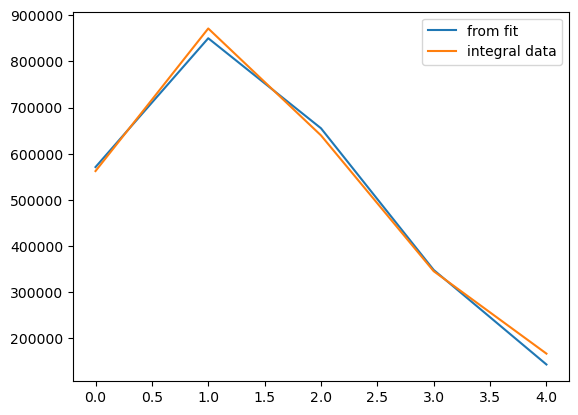

In [5]:
##temporary imports
from scipy.optimize import curve_fit
import mplhep
import zfit
import numpy as np
from scipy.special import factorial
import matplotlib.pyplot as plt
import sipmpdf.pdf as PDF

#gain and pedestal estimates
def linear(z,pedestal,gain):
  return pedestal+z*gain

popt, popc = curve_fit(linear, range(len(gauss_dict["mu"])), gauss_dict["mu"])

pedestal_est=popt[0]
gain_est=popt[1]
pedestal_err_est=np.sqrt(popc[0][0])
gain_err_est=np.sqrt(popc[1][1])

print("Pedestal estimate: ",pedestal_est)
print("Gain estimate:", gain_est)

#common noise and pixel noise estimates
def noise(z,common_noise,pixel_noise):
  return np.sqrt(common_noise*common_noise+z*pixel_noise*pixel_noise)

popt, popc = curve_fit(noise,range(len(gauss_dict["sigma"])),gauss_dict["sigma"],bounds=(0,100))

common_noise_est=popt[0]
pixel_noise_est=popt[1]
common_noise_err_est=np.sqrt(popc[0][0])
pixel_noise_err_est=np.sqrt(popc[1][1])

print("Common noise estimate: ",common_noise_est)
print("Pixel noise estimate: ",pixel_noise_est)

#mean and lambda estimates
def height(z,N,mu,l):
  y=(mu+(z*l))

  result=np.exp(-np.log(factorial(z))+np.log(mu)+np.log(N)+(z-1)*np.log(y)-y)
  return result


integrals_total=sum(gauss_dict["integral"])
popt, popc = curve_fit(height,np.arange(stop=len(gauss_dict["integral"]),step=1),gauss_dict["integral"],p0=(integrals_total,2.5,.05),bounds=([integrals_total-50000,.1,0],[integrals_total+50000,5,.2]))

simple=np.linspace(0,len(gauss_dict["integral"])-1,len(gauss_dict["integral"]))
plt.plot(simple,height(simple,popt[0],popt[1],popt[2]),label="from fit")
plt.plot(simple,gauss_dict["integral"],label="integral data")
plt.legend()

poisson_mean_est=popt[1]
poisson_borel_est=popt[2]

print("Generalized Poisson Mean estimate: ",poisson_mean_est)
print("Poisson Borel estimate: ",poisson_borel_est)
  


In [6]:
#parameter guess
pedestal_t = pedestal_est
gain_t = gain_est
common_noise_t = common_noise_est
pixel_noise_t = pixel_noise_est
poisson_mean_t = poisson_mean_est
poisson_borel_t = poisson_borel_est
ap_beta_t = 100
ap_prob_t = 0.05
dc_prob_t = 0.01
dc_res_t = 5e-3
N_Events = 100_000

#Ensure all limits make sense
lower_common_noise_bound=common_noise_t-2
if lower_common_noise_bound<0:
  lower_common_noise_bound=0

lower_pixel_noise_bound=pixel_noise_t-5
if lower_pixel_noise_bound<0:
  lower_pixel_noise_bound=0

lower_poisson_mean=poisson_mean_t-2
if lower_poisson_mean<0:
  lower_poisson_mean=0

lower_poisson_borel=poisson_borel_t-.1
if lower_poisson_borel<0:
  lower_poisson_borel=0

#Define limits for parameters in fit and initial guesses
pedestal = zfit.Parameter('pedestal value', pedestal_t, pedestal_t-10, pedestal_t+10)
gain = zfit.Parameter('gain', gain_t, gain_t-20, gain_t+20)
common_noise = zfit.Parameter('common_noise', common_noise_t, lower_common_noise_bound, common_noise_t+3)
pixel_noise = zfit.Parameter('pixel_noise', pixel_noise_t, lower_pixel_noise_bound, pixel_noise_t+5)
poisson_mean = zfit.Parameter('poisson_mean', poisson_mean_t, lower_poisson_mean, poisson_mean_t+2)
poisson_borel = zfit.Parameter('poisson_borel', poisson_borel_t, lower_poisson_borel, poisson_borel_t+.1)
ap_beta = zfit.Parameter('ap_beta', ap_beta_t, 20, 120)
ap_prob = zfit.Parameter('ap_prob', ap_prob_t, 0.0, 0.2)
dc_prob = zfit.Parameter('dc_prob', dc_prob_t, 0.0, 1)
dc_res = zfit.param.ConstantParameter('dc_res', dc_res_t)
obs = zfit.Space('x', limits=(-200, +1500))

In [7]:
#Create pdf for low light response
pdf = PDF.SiPMResponsePDF(obs=obs,
                                  pedestal=pedestal,
                                  gain=gain,
                                  ap_beta=ap_beta,
                                  ap_prob=ap_prob,
                                  common_noise=common_noise,
                                  pixel_noise=pixel_noise,
                                  poisson_mean=poisson_mean,
                                  poisson_borel=poisson_borel,
                                  dc_prob=dc_prob,
                                  dc_res=dc_res)

# Declaring the binned phase space in PDF
binning = zfit.binned.RegularBinning(400, -200, 1500, name="x")
obs_bin = zfit.Space("x", binning=binning)
pdf_bin = zfit.pdf.BinnedFromUnbinnedPDF(pdf, obs_bin)

# Making the data container
data_unbinned = zfit.Data.from_numpy(obs=obs, array=np.array(import_data_results["raw_data"]))
data_bin = data_unbinned.to_binned(obs_bin)

# Running the fit
nll_bin = zfit.loss.BinnedNLL(pdf_bin, data_bin)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_bin)
result.hesse()
result

/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.sum. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/sipmpdf/kernel.py:78: UserWarning: Using tensorflow.experimental.numpy.power. Make sure the functionality has been implemented!
  warnings.warn(
/srv/.env/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1180: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_f

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x7f80f7d44760>] data=[<zfit._data.binneddatav1.BinnedData object at 0x7f808c63b640>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm   │ min value   │
╞═════════╪═════════════╪══════════════════╪═══════╪═════════════╡
│ False   │ False       │ True             │ 0.022 │ 42617.34    │
╘═════════╧═════════════╧══════════════════╧═══════╧═════════════╛

Parameters
name              value  (rounded)        hesse    at limit
--------------  ------------------  -----------  ----------
pedestal value             5.71693  +/-   0.012       False
gain                       175.054  +/-  0.0012       False
common_noise               3.94276  +/-   0.012       False
pixel_noise                8.09675  +/-   9e-05       False
poisson_mean               1.60293  +/-   0.002       False
poisson_borel

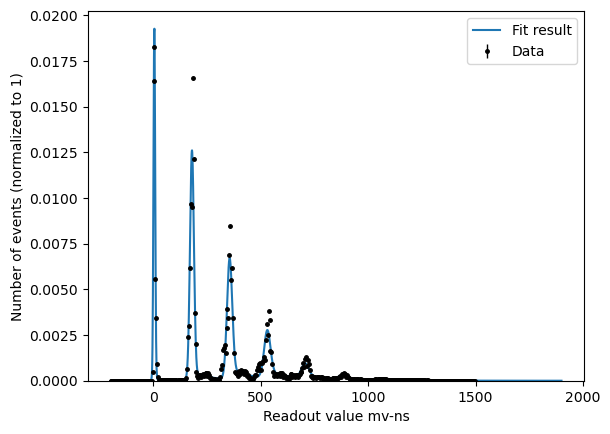

In [8]:
h = data_bin.to_hist()  # Converting to a histogram container
x = np.linspace(-100, 1900, 2000)
y = zfit.run(pdf.pdf(x))
ax = mplhep.histplot(h,
                     density=True,
                     label='Data',
                     histtype='errorbar',
                     color='k',
                     markersize=5)

plt.plot(x, y, label='Fit result')
plt.xlabel('Readout value mv-ns')
plt.ylabel('Number of events (normalized to 1)')
plt.legend()

In [9]:
endtime=datetime.datetime.now()
print(endtime)
print(endtime-starttime)

2023-08-16 04:10:41.461233
0:22:14.977105
